In [ ]:
# default_exp modeling.question_answering

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
#export
import ast

import torch
from transformers import *
from fastai2.text.all import *

from blurr.data.all import *
from blurr.modeling.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    """We need to return everything from the model for question/answer tasks"""
    def after_pred(self): self.learn.pred = self.pred

In [ ]:
#export
class HF_QstAndAnsModelWrapper(HF_BaseModelWrapper):
    """A custom model wrapper for question answer models since we need all the outputs (not just the first)"""
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('attention_mask', x[1])): model_kwargs['attention_mask'] = x[1]
        if (self._include_arg('token_type_ids', x[2])): model_kwargs['token_type_ids'] = x[2]
        if (self._include_arg('cls_index', x[3])): model_kwargs['cls_index'] = x[3]
        if (self._include_arg('p_mask', x[4])): model_kwargs['p_mask'] = x[4]
        
        return self.hf_model(**model_kwargs)

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}], 
                 weights=[1, 1], reduction='mean'):
        
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self, 'loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
path = Path('./')
squad_df = pd.read_csv(path/'squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33
1,Cyprus,"Following the death in 1473 of James II, the last Lusignan king, the Republic of Venice assumed control of the island, while the late king's Venetian widow, Queen Catherine Cornaro, reigned as figurehead. Venice formally annexed the Kingdom of Cyprus in 1489, following the abdication of Catherine. The Venetians fortified Nicosia by building the Venetian Walls, and used it as an important commercial hub. Throughout Venetian rule, the Ottoman Empire frequently raided Cyprus. In 1539 the Ottomans destroyed Limassol and so fearing the worst, the Venetians also fortified Famagusta and Kyrenia.",572e7f8003f98919007566df,In what year did the Ottomans destroy Limassol?,False,1539,481,485


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_tokenizer_cls = BertTokenizer
hf_model_cls = HF_MODELS.BertForQuestionAnswering

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
                                                                               hf_tokenizer_cls,
                                                                               hf_model_cls)


# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

# # here's a pre-trained xlm model for squad you can try too
# pretrained_model_name = 'xlm-mlm-ende-1024'
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

In [ ]:
squad_df = squad_df.apply(partial(pre_process_squad, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (16 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
#hide
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33,"[[CLS], what, does, f, ##d, ##ny, stand, for, ?, [SEP], the, new, york, city, fire, department, (, f, ##d, ##ny, ), ,, provides, fire, protection, ,, technical, rescue, ,, primary, response, to, biological, ,, chemical, ,, and, radioactive, hazards, ,, and, emergency, medical, services, for, the, five, boroughs, of, new, york, city, ., the, new, york, city, fire, department, is, the, largest, municipal, fire, department, in, the, united, states, and, the, second, largest, in, the, world, after, the, tokyo, fire, department, ., the, f, ##d, ##ny, employs, approximately, 11, ,, 08, ##0, unif...",123,11,16
5,Communications_in_Somalia,"The Somali Postal Service (Somali Post) is the national postal service of the Federal Government of Somalia. It is part of the Ministry of Information, Posts and Telecommunication.",56e1b959cd28a01900c67ad1,What is the name of the National postal service of Somalia?,False,Somali Post,4,15,"[[CLS], what, is, the, name, of, the, national, postal, service, of, somalia, ?, [SEP], the, somali, postal, service, (, somali, post, ), is, the, national, postal, service, of, the, federal, government, of, somalia, ., it, is, part, of, the, ministry, of, information, ,, posts, and, telecommunication, ., [SEP]]",48,19,21


In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'
hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, max_seq_len=max_seq_len, truncation_strategy=trunc_strat, 
                                 task=ForQuestionAnsweringTask())

blocks = (
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm), 
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

def get_x(x):
    return (x.question_text, x.context) if (hf_tokenizer.padding_side == 'right') else (x.context, x.question_text)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[0], dls.vocab[1]

(2, (#128) [0,1,2,3,4,5,6,7,8,9...], (#128) [0,1,2,3,4,5,6,7,8,9...])

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,start/end,answer
0,"the goal is to get how many residents to sign up? another initiative, presented by the late mayor thomas menino, is the renew boston whole building incentive, which reduces the cost of living in buildings that are deemed energy efficient. this, much like the green housing developments, gives people of low socioeconomic status an opportunity to find housing in communities that support the environment. the ultimate goal of this initiative is to enlist 500 bostonians to participate in a free, in - home energy assessment.","(85, 86)",500
1,"axons grouped together are known as what? most of the space in the brain is taken up by axons, which are often bundled together in what are called nerve fiber tracts. a myelinated axon is wrapped in a fatty insulating sheath of myelin, which serves to greatly increase the speed of signal propagation. ( there are also unmyelinated axons ). myelin is white, making parts of the brain filled exclusively with nerve fibers appear as light - colored white matter, in contrast to the darker - colored grey matter that marks areas with high densities of neuron cell bodies.","(34, 37)",nerve fiber tracts


In [ ]:
model = HF_QstAndAnsModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()                # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(x)
len(preds),preds[0].shape

(2, torch.Size([4, 128]))

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=1.9054607152938843)

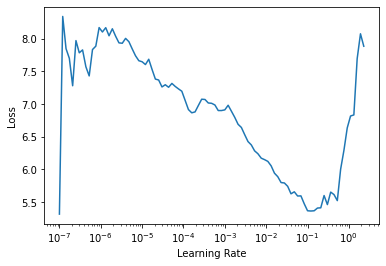

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.527988,2.148649,00:04
1,3.026729,1.596865,00:04
2,2.519502,1.550026,00:04


In [ ]:
#export
@typedispatch
def show_results(x:HF_QuestionAnswerInput, y, samples, outs, hf_tokenizer, skip_special_tokens=True, 
                 ctxs=None, max_n=6, **kwargs):        
    
    samples = L()
    for inp, start, end, pred in zip(x[0], *y, outs):
        txt = hf_tokenizer.decode(inp, skip_special_tokens=skip_special_tokens).replace(hf_tokenizer.pad_token, '')
        ans_toks = hf_tokenizer.convert_ids_to_tokens(inp, skip_special_tokens=False)[start:end]
        pred_ans_toks = hf_tokenizer.convert_ids_to_tokens(inp, skip_special_tokens=False)[int(pred[0]):int(pred[1])]
        
        samples.append((txt,
                       (start.item(),end.item()), hf_tokenizer.convert_tokens_to_string(ans_toks),
                       (int(pred[0]),int(pred[1])), hf_tokenizer.convert_tokens_to_string(pred_ans_toks)))

    df = pd.DataFrame(samples, columns=['text', 'start/end', 'answer', 'pred start/end', 'pred answer'])
    display_df(df[:max_n])
    return ctxs

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, skip_special_tokens=True, max_n=2)

,text,start/end,answer,pred start/end,pred answer
0,"what all mostly use lossy compression? the majority of video compression algorithms use lossy compression. uncompressed video requires a very high data rate. although lossless video compression codecs perform at a compression factor of 5 - 12, a typical mpeg - 4 lossy compression video has a compression factor between 20 and 200. as in all lossy compression, there is a trade - off between video quality, cost of processing the compression and decompression, and system requirements. highly compressed video may present visible or distracting artifacts.","(13, 16)",video compression algorithms,"(13, 20)",video compression algorithms use lossy compression
1,"where is the canadian joint incident response unit based? the canadian special operations forces command ( cansofcom ) is a formation capable of operating independently but primarily focused on generating special operations forces ( sof ) elements to support cjoc. the command includes joint task force 2 ( jtf2 ), the canadian joint incident response unit ( cjiru ) based at cfb trenton, as well as the canadian special operations regiment ( csor ) and 427 special operations aviation squadron ( soas ) based at cfb petawawa.","(75, 78)",cfb trenton,"(75, 78)",cfb trenton


In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question_text': 'What did George Lucas make?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.predict(inf_df.iloc[0])

(('11', '12'),
 tensor([11]),
 tensor([[2.2636e-05, 9.8986e-06, 1.0359e-06, 2.2825e-06, 1.0695e-06, 1.9311e-06,
          1.3691e-07, 2.2636e-05, 1.2856e-03, 8.8090e-05, 4.0246e-03, 9.9340e-01,
          9.7106e-05, 2.7556e-05, 7.2899e-05, 2.2804e-05, 5.3262e-04, 2.2608e-04,
          4.2580e-06, 9.2997e-05, 9.8021e-06, 2.2631e-05, 2.2707e-05, 9.2759e-08,
          1.0251e-07, 9.6612e-08, 9.6793e-08, 9.7804e-08, 1.0187e-07, 1.0202e-07,
          9.5333e-08, 9.7713e-08, 1.0058e-07, 9.9367e-08, 9.2049e-08, 8.9756e-08,
          9.4178e-08, 9.3889e-08, 8.9697e-08, 9.0312e-08, 9.1416e-08, 9.4888e-08,
          9.6918e-08, 9.4050e-08, 9.7649e-08, 9.8445e-08, 9.7950e-08, 9.7025e-08,
          9.7672e-08, 9.7807e-08, 1.0151e-07, 9.9924e-08, 9.9161e-08, 1.0099e-07,
          1.0609e-07, 1.0592e-07, 1.0360e-07, 1.0004e-07, 1.0069e-07, 1.0668e-07,
          1.0468e-07, 9.8762e-08, 9.6865e-08, 1.0002e-07, 1.0588e-07, 9.9850e-08,
          9.6508e-08, 9.8459e-08, 9.9280e-08, 1.0342e-07, 9.8909e-08

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question_text': 'When was Star Wars made?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp, probs, _, preds = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp[0].tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,1.856852,1.336007,00:14
1,1.781783,1.210732,00:14
2,1.775833,1.184251,00:14


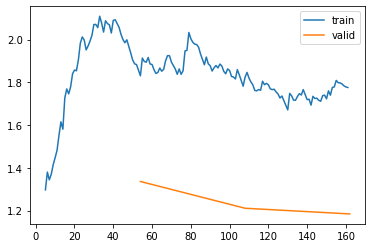

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,start/end,answer,pred start/end,pred answer
0,"what all mostly use lossy compression? the majority of video compression algorithms use lossy compression. uncompressed video requires a very high data rate. although lossless video compression codecs perform at a compression factor of 5 - 12, a typical mpeg - 4 lossy compression video has a compression factor between 20 and 200. as in all lossy compression, there is a trade - off between video quality, cost of processing the compression and decompression, and system requirements. highly compressed video may present visible or distracting artifacts.","(13, 16)",video compression algorithms,"(13, 14)",video
1,"why is hydrogen employed? hydrogen is employed to saturate broken ( "" dangling "" ) bonds of amorphous silicon and amorphous carbon that helps stabilizing material properties. it is also a potential electron donor in various oxide materials, including zno, sno2, cdo, mgo, zro2, hfo2, la2o3, y2o3, tio2, srtio3, laalo3, sio2, al2o3, zrsio4, hfsio4, and srzro3.","(10, 38)","to saturate broken ( "" dangling "" ) bonds of amorphous silicon and amorphous carbon that helps stabilizing material properties","(10, 38)","to saturate broken ( "" dangling "" ) bonds of amorphous silicon and amorphous carbon that helps stabilizing material properties"


In [ ]:
learn.predict(inf_df.iloc[0])

(('14', '15'),
 tensor([14]),
 tensor([[5.5352e-05, 2.2554e-05, 4.0935e-06, 2.3330e-06, 1.2443e-06, 9.4030e-06,
          8.5103e-07, 5.5354e-05, 1.2332e-04, 2.5622e-05, 1.3557e-04, 2.4048e-04,
          7.8244e-06, 7.7916e-03, 9.9137e-01, 6.0191e-06, 5.7455e-06, 4.6348e-06,
          9.6538e-07, 3.9185e-06, 3.7031e-06, 5.5341e-05, 5.5379e-05, 2.0431e-07,
          2.3085e-07, 2.1621e-07, 2.1600e-07, 2.1055e-07, 2.1659e-07, 2.0518e-07,
          2.0707e-07, 2.0689e-07, 2.2457e-07, 2.2310e-07, 2.0423e-07, 2.0389e-07,
          2.0606e-07, 2.0444e-07, 2.0247e-07, 2.0467e-07, 1.9861e-07, 2.0241e-07,
          2.0957e-07, 2.0683e-07, 2.0625e-07, 2.0811e-07, 2.0390e-07, 2.0685e-07,
          2.0878e-07, 2.0663e-07, 2.2683e-07, 2.1609e-07, 2.1335e-07, 2.1546e-07,
          2.1513e-07, 2.2060e-07, 2.1512e-07, 2.1390e-07, 2.1278e-07, 2.3498e-07,
          2.3390e-07, 2.1623e-07, 2.1476e-07, 2.1618e-07, 2.2024e-07, 2.1261e-07,
          2.1458e-07, 2.1205e-07, 2.1234e-07, 2.3674e-07, 2.1312e-07

In [ ]:
preds, pred_classes, probs = learn.predict(inf_df.iloc[0])
preds

('14', '15')

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0]):int(preds[1])]

['1977']

And what about inference?

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'question_text': 'Who created Star Wars?', 
     'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'}],
    orient='columns')

inf_learn.predict(inf_df.iloc[0])

(('7', '9'),
 tensor([7]),
 tensor([[1.6396e-05, 1.9600e-06, 6.0457e-07, 1.7729e-06, 3.8644e-07, 1.8696e-07,
          1.6398e-05, 9.9927e-01, 5.4307e-04, 4.0274e-06, 2.9134e-05, 8.7776e-07,
          6.7870e-06, 4.3703e-05, 7.0748e-07, 2.4122e-05, 1.7828e-06, 2.7630e-07,
          1.2480e-06, 5.7405e-07, 1.6395e-05, 1.6296e-05, 6.7992e-08, 7.8709e-08,
          7.2059e-08, 7.1007e-08, 7.2706e-08, 7.1762e-08, 7.2937e-08, 6.9061e-08,
          6.9060e-08, 8.1308e-08, 7.7751e-08, 6.8892e-08, 6.7077e-08, 6.8780e-08,
          6.7826e-08, 6.7657e-08, 7.0609e-08, 6.9290e-08, 6.9801e-08, 7.0823e-08,
          7.1794e-08, 7.0623e-08, 7.1665e-08, 7.2203e-08, 7.1304e-08, 7.3125e-08,
          7.2831e-08, 7.7362e-08, 7.9157e-08, 7.5425e-08, 7.3189e-08, 7.3604e-08,
          7.4873e-08, 7.4652e-08, 7.3135e-08, 7.2247e-08, 8.1196e-08, 8.1190e-08,
          7.2770e-08, 7.2002e-08, 7.1767e-08, 7.1913e-08, 7.4005e-08, 7.2579e-08,
          7.2577e-08, 7.2451e-08, 7.5836e-08, 7.5871e-08, 7.2599e-08, 7

In [ ]:
inp_ids = hf_tokenizer.encode('Who created Star Wars?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[7:9]

['george', 'lucas']

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted index.ipynb.
